In [1]:
import dgl
import os
import sys
import pickle
import scipy.sparse as ss
print(os.getcwd())
sys.path.append('/data/kenlay/DyNNet/')
from src.utils.functions import load_model, load_sequence, prepare_batches, add_features_dataset, normalise_statistics, dist_labels_to_changepoint_labels, dist_labels_to_changepoint_labels_adjusted
from src.utils.misc import get_device
from src.detect import compute_sgnn_similarity
from src.utils.baselines import laplacian_spectrum_similarity, NCPD, CUMSUM, CUMSUM_2, avg_deltacon_similarity, avg_wl_distance, avg_frobenius_distance, avg_procrustes_distance, \
    distance_procrustes_LE, evaluate_baseline
from src.utils.graphs import laplacian_embeddings, norm_laplacian, laplacian, degree_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy
import grakel
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from src.utils.metrics import find_best_threshold, adjust_predicts_donut, binary_metrics_adj, best_f1_search_grid, compute_ari
from pathlib import PosixPath
import json

/data/kenlay/miniconda3/envs/deborah/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/kenlay/DyNNet/notebooks


### Example of change-point detection in a dynamic network with one or multiple events

In [2]:
# Generate dynamic network sequence with two change point of type clique (for training and validation)
#%run /data/kenlay/DyNNet/src/dysbm/clique.py --n_changes 2 --n_nodes 400 --size_clique 80 --p 0.1 --q 0.03 --n_samples 100 --sequence

# Generate dynamic network sequence with 3 change points of type clique (for testing)
#%run /data/kenlay/DyNNet/src/dysbm/clique.py --n_changes 3 --n_nodes 400 --size_clique 80 --p 0.1 --q 0.03 --n_samples 100 --sequence

# Generate dynamic network sequence with one change point of type merge
#%run /data/kenlay/DyNNet/src/dysbm/merge.py --sizes_1 50 50 --sizes_2 20 30 30 20 --p 0.2 --q 0.1 --n_samples 50 --sequence

# Generate dynamic network sequence with one change point of type swap
#%run /data/kenlay/DyNNet/src/dysbm/swap.py --sizes 150 50 200 --p 0.2 --q 0.1 --n_samples 50 --permute_rate 0.2 --sequence

In [3]:
# Load training data
# training_data_path = '/data/kenlay/DyNNet/data/synthetic/03_27_08:36:06_clique_cp_4_T_400_n_400_p_0.08_q_0.02_30_0/'
# with open(training_data_path + 'data.p', 'rb') as f:
#     training_data = pickle.load(f)
# with open(training_data_path + 'labels.p', 'rb') as f:
#     training_labels = pickle.load(f)
# print(training_labels)

In [4]:
# Train a GSL model
# %run /data/kenlay/DyNNet/src/train.py --nepochs 100 --training_data {data_path} --save_folder '/data/kenlay/DyNNet/results/synthetic/' --cuda 3 --validation_proportion 0.5 --test_proportion 0.0 --features identity --n_pairs 5000 --pair_sampling 'random' --hidden 64 --top_k 100 --lr 0.001

In [14]:
# Detect change-points in a test sequence
test_data = '/data/kenlay/DyNNet/data/synthetic/03_27_07:53:42_clique_cp_4_T_400_n_400_p_0.08_q_0.02_70_9/'
model_path = '/data/kenlay/DyNNet/results/synthetic/03_31_21:56_gsl_model_epochs_100_lr_0.01_feat_identity'
# %run /data/kenlay/DyNNet/src/detect.py --test_data {test_data} --save_dir '/data/kenlay/DyNNet/results/synthetic/' --cuda 3 --model_path {model_path} \
# --window_length 6 --task 'detection' --tolerance 3

In [15]:
# Plot results
# res_path = '/data/kenlay/DyNNet/results/synthetic/NCPD_03_03_11:14:23_window_6_detection_features_identity/'
# with open(res_path + 'est_cps.p', 'rb') as f:
#     est_cps = pickle.load(f)
# with open(res_path + 'est_labels.p', 'rb') as f:
#     est_labels = pickle.load(f)
# with open(res_path + 'avg_similarity.p', 'rb') as f:
#     avg_sim = pickle.load(f)
# with open(res_path + 'times.p', 'rb') as f:
#     idx = pickle.load(f)

In [16]:
# Load model
model, model_args = load_model(model_path, device=torch.device(f"cuda:{0}"))
# Load test data
data, true_labels, true_cps = load_sequence(test_data)

Model loaded
Data loaded: sequence of 400 graphs with a change point at time [53, 100, 151, 200, 234, 300, 371]


In [27]:
# Predictions
avg_sim, idx = compute_sgnn_similarity(model, data, 5)

# Change points
est_labels = (avg_sim < 0.5).astype(int)
est_labels = np.insert(((est_labels[1:] == 1) * (est_labels[:-1] == 0)).astype(int), 0, 0)
est_cps = np.where(est_labels == 1)[0]

Using cuda with cuda 7


(0.0, 1.1)

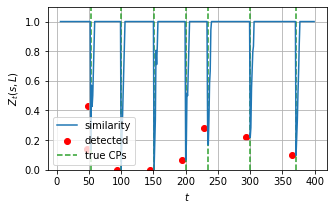

In [28]:
# Plot similarity statistics
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(idx, avg_sim, label='similarity')
#ax.plot(idx, est_labels, label='similarity')
ax.scatter(est_cps, avg_sim[est_cps], label='detected', color='red')
ax.vlines(x=true_cps, ymin=0, ymax=1.1, linestyles='dashed', label='true CPs', color='tab:green')
ax.legend(loc='best')
ax.grid(visible=True)
ax.set_xlabel(rf'$t$')
ax.set_ylabel(rf'$Z_t(s,L)$')
ax.set_ylim(0,1.1)
#plt.savefig(f"/data/hylacola/sulem/PycharmProjects/Scalable_VB_Hawkes/results/figures/estim_theta_D{number_of_dimensions}D_{scenario}_estim_theta.pdf")

In [29]:
true_cps

(394,)
(400,)
(400,)


In [30]:
idx[est_cps]

1.0

In [23]:
ari = compute_ari(idx[est_cps], true_cps, T=400)
ari

[53, 100, 151, 200, 234, 300, 371]

In [25]:
# Baselines
lad, lad_times = laplacian_spectrum_similarity(data, window_length=6,normalize=True, n_eigen=3)

(403,)

In [11]:
ncpd, ncpd_times = NCPD(data, window_length=6, n_eigen=3, normalize=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:17<00:00, 16.61it/s]


In [12]:
cusum, cusum_times = CUMSUM(data, window_length=6)
cusum_2, cusum_2_times = CUMSUM_2(data, window_length=6)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:09<00:00, 31.93it/s]


In [13]:
# Quite long
deltacon, dc_times = avg_deltacon_similarity(data, window_length=6,diff=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [01:32<00:00,  3.20it/s]


In [14]:
frobenius, fb_times = avg_frobenius_distance(data, window_length=6,diff=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 799.51it/s]


In [15]:
procrustes, pc_times = avg_procrustes_distance(data, window_length=6, n_eigen=4,diff=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [01:03<00:00,  4.66it/s]


In [16]:
wl_distance, wl_times = avg_wl_distance(data, window_length=6,diff=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:48<00:00,  6.07it/s]


In [17]:
# Normalise every baseline to get statistics between 0 and 1
lad_norm = normalise_statistics(lad) #  - min(lad)) / max(lad)
ncpd_norm = normalise_statistics(ncpd)
cusum_norm = normalise_statistics(cusum)
cusum_2_norm = normalise_statistics(cusum_2)
deltacon_norm = normalise_statistics(deltacon)
frobenius_norm = normalise_statistics(frobenius)
procrustes_norm = normalise_statistics(procrustes)
wl_norm = normalise_statistics(wl_distance)

In [18]:
frobenius_norm = np.abs(frobenius_norm[1:] - frobenius_norm[:-1])
fb_times = fb_times[1:]

Text(0.5, 0, '$t$')

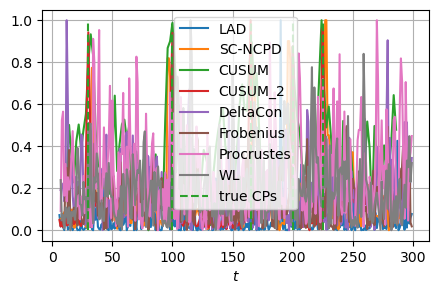

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(lad_times, lad_norm, label='LAD')
ax.plot(ncpd_times, ncpd_norm, label='SC-NCPD')
ax.plot(cusum_times, cusum_norm, label='CUSUM')
ax.plot(cusum_2_times, cusum_2_norm, label='CUSUM_2')
ax.plot(dc_times, deltacon_norm, label='DeltaCon')
ax.plot(fb_times, frobenius_norm, label='Frobenius')
ax.plot(pc_times, procrustes_norm, label='Procrustes')
ax.plot(wl_times, wl_norm, label='WL')
ax.vlines(x=true_cps, ymin=0, ymax=max(ncpd_norm), linestyles='dashed', label='true CPs', color='tab:green')
ax.legend(loc='best')
ax.grid(visible=True)
ax.set_xlabel(rf'$t$')
#ax.set_ylabel(rf'$Z_t(s,L)$')

In [20]:
# Evaluate baselines
for method in ['ncpd', 'lad', 'cusum', 'cusum_2', 'frobenius', 'procrustes', 'wl']:
    ncpd_f1, ncpd_f1_train, ncpd_thresh = evaluate_baseline(method, training_data, training_labels, data, true_labels, window_length=6, tolerance=3, n_eigen=4, diff=True)
    print("Method : ", method)
    print("Selected threshold : ", ncpd_thresh)
    print("F1 test and train scores : ", ncpd_f1, ncpd_f1_train)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:17<00:00, 16.33it/s]


Method :  ncpd
Selected threshold :  0.4646464646464647
F1 test and train scores :  0.888888888888889 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 19502.22it/s]


Method :  lad
Selected threshold :  0.22222222222222224
F1 test and train scores :  0.6141732283464566 0.8387096774193548


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:02<00:00, 64.45it/s]


Method :  cusum
Selected threshold :  0.7676767676767677
F1 test and train scores :  1.0 1.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:09<00:00, 30.89it/s]


Method :  cusum_2
Selected threshold :  0.5353535353535354
F1 test and train scores :  1.0 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 754.21it/s]


Method :  frobenius
Selected threshold :  0.38383838383838387
F1 test and train scores :  0.8904109589041096 0.7428571428571429


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [01:03<00:00,  4.64it/s]


Method :  procrustes
Selected threshold :  0.393939393939394
F1 test and train scores :  0.7103825136612022 0.7358490566037735


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:57<00:00,  5.08it/s]


Method :  wl
Selected threshold :  0.888888888888889
F1 test and train scores :  0.0 1.0
